In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/hayden/Desktop/provincial council internship/df.csv', encoding='utf-8')

# # 데이터 전처리
# df['MSR_DT'] = pd.to_datetime(df['MSR_DT'], format='%Y%m%d%H', errors='coerce')
# df['day_of_year'] = df['MSR_DT'].dt.dayofyear
# df['month'] = df['MSR_DT'].dt.month

# 문자열 피처 처리
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '적설(cm)', '전운량(10분위)', 'PM25', 'PM10', 'O3', 'CO', 'SO2', 'NO2']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['STTN_NM'])
    ],
    remainder='passthrough'
)

# 데이터 준비
X = df[['STTN_NM', 'MSR_DT', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '적설(cm)', '전운량(10분위)', 'PM25', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]
y = df[['PM25', 'PM10']]

# 날짜를 수치형으로 변환
X['MSR_DT'] = X['MSR_DT'].apply(lambda x: pd.to_datetime(x).toordinal())

# 피처 및 타겟 정규화
X_preprocessed = preprocessor.fit_transform(X)
scaler_targets = StandardScaler()
y_scaled = scaler_targets.fit_transform(y)

# 시퀀스 데이터 생성
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = targets[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # 예를 들어, 30일의 시퀀스
X_sequences, y_sequences = create_sequences(X_preprocessed, y_scaled, seq_length)

# 데이터 분할
split = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:split], X_sequences[split:]
y_train, y_test = y_sequences[:split], y_sequences[split:]


In [5]:
# 모델 정의
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)
])

model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)


Epoch 1/50
6028/6028 [==============================] - 43s 7ms/step - loss: 536460448.0000 - val_loss: 1.4360
Epoch 2/50
6028/6028 [==============================] - 43s 7ms/step - loss: 1.6128 - val_loss: 12.8151
Epoch 3/50
6028/6028 [==============================] - 42s 7ms/step - loss: 15370.9375 - val_loss: 2263.7598
Epoch 4/50
6028/6028 [==============================] - 43s 7ms/step - loss: 9216.8818 - val_loss: 5705.6768
Epoch 5/50
6028/6028 [==============================] - 43s 7ms/step - loss: 5361.1074 - val_loss: 1114.5468
Epoch 6/50
6028/6028 [==============================] - 43s 7ms/step - loss: 3152.4055 - val_loss: 12704.0283
Epoch 7/50
6028/6028 [==============================] - 46s 8ms/step - loss: 2295.6099 - val_loss: 5.3401
Epoch 8/50
6028/6028 [==============================] - 48s 8ms/step - loss: 1692.5343 - val_loss: 5.6756
Epoch 9/50
6028/6028 [==============================] - 45s 8ms/step - loss: 1235.2623 - val_loss: 244.9550
Epoch 10/50
6028/6028 [====

In [6]:
# 예측
y_pred_scaled = model.predict(X_test)
y_pred = scaler_targets.inverse_transform(y_pred_scaled)
y_test_actual = scaler_targets.inverse_transform(y_test)

1884/1884 [==============================] - 4s 2ms/step


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/hayden/Desktop/provincial council internship/df.csv', encoding='utf-8')


# 예측 결과가 포함된 데이터프레임을 생성
pred_dates = pd.date_range(start='2024-08-01', end='2025-08-01', freq='D')  
pred_df = pd.DataFrame({
    'date': pred_dates,
    'PM25': np.random.uniform(0, 150, len(pred_dates)),  # 예시 데이터
    'PM10': np.random.uniform(0, 150, len(pred_dates))
})

# 날짜 열을 날짜/시간 데이터 타입으로 변환
pred_df['date'] = pd.to_datetime(pred_df['date'])

# 날짜 기반 추가적인 피처 생성
pred_df['month'] = pred_df['date'].dt.month
pred_df['season'] = pred_df['month'] % 12 // 3 + 1
season_map = {1: '겨울', 2: '봄', 3: '여름', 4: '가을'}
pred_df['season'] = pred_df['season'].map(season_map)

# 농도 카테고리화 함수 정의
def categorize_pm(value):
    if value <= 15:
        return '매우 좋음'
    elif value <= 35:
        return '좋음'
    elif value <= 75:
        return '보통'
    elif value <= 115:
        return '나쁨'
    else:
        return '매우 나쁨'

# 카테고리화
pred_df['PM25_category'] = pred_df['PM25'].apply(categorize_pm)
pred_df['PM10_category'] = pred_df['PM10'].apply(categorize_pm)


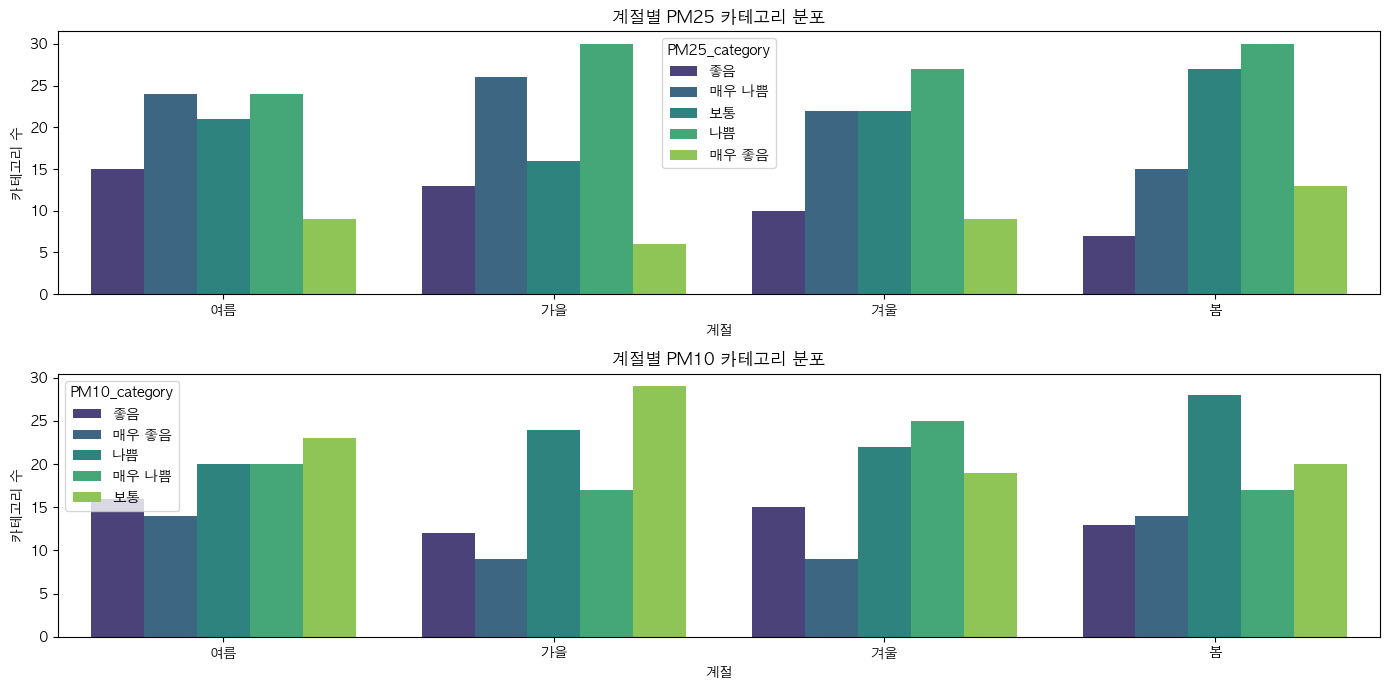

In [12]:

plt.rcParams['font.family'] = 'AppleGothic'

plt.figure(figsize=(14, 7))

# PM25 계절별 카테고리 분포
plt.subplot(2, 1, 1)
sns.countplot(data=pred_df, x='season', hue='PM25_category', palette='viridis')
plt.title('계절별 PM25 카테고리 분포')
plt.xlabel('계절')
plt.ylabel('카테고리 수')

# PM10 계절별 카테고리 분포
plt.subplot(2, 1, 2)
sns.countplot(data=pred_df, x='season', hue='PM10_category', palette='viridis')
plt.title('계절별 PM10 카테고리 분포')
plt.xlabel('계절')
plt.ylabel('카테고리 수')

plt.tight_layout()
plt.show()


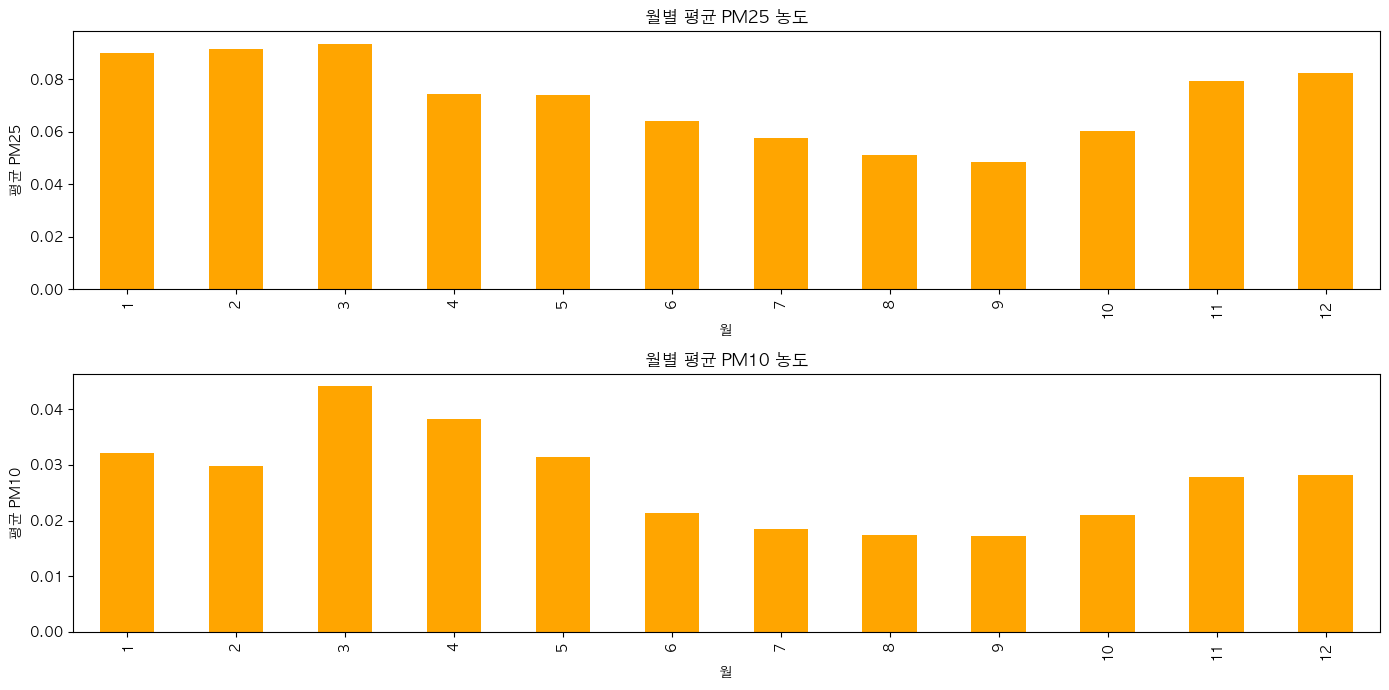

In [15]:

df['MSR_DT'] = pd.to_datetime(df['MSR_DT'], format='%Y%m%d%H', errors='coerce')
df['Year'] = df['MSR_DT'].dt.year
df['Month'] = df['MSR_DT'].dt.month
df['Hour'] = df['MSR_DT'].dt.hour

# 월별 평균 계산
monthly_avg = df.groupby('Month').mean(numeric_only=True)


plt.figure(figsize=(14, 7))

# PM25 월별 평균 시각화
plt.subplot(2, 1, 1)
monthly_avg['PM25'].plot(kind='bar', color='orange')
plt.title('월별 평균 PM25 농도')
plt.xlabel('월')
plt.ylabel('평균 PM25')

# PM10 월별 평균 시각화
plt.subplot(2, 1, 2)
monthly_avg['PM10'].plot(kind='bar', color='orange')
plt.title('월별 평균 PM10 농도')
plt.xlabel('월')
plt.ylabel('평균 PM10')

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 예제 데이터프레임 생성 (여기서는 가정된 데이터입니다)
# 실제 데이터프레임을 불러와서 사용하는 것을 권장합니다
pred_dates = pd.date_range(start='2024-08-01', end='2025-08-01', freq='H')  # 예를 들어, 예측 시간 범위
pred_df = pd.DataFrame({
    'date': pred_dates,
    'PM25': np.random.uniform(0, 150, len(pred_dates)),  # 예시 데이터
    'PM10': np.random.uniform(0, 150, len(pred_dates))
})

# 날짜 열을 날짜/시간 데이터 타입으로 변환
pred_df['date'] = pd.to_datetime(pred_df['date'])

# 시간대별 평균 계산
pred_df['hour'] = pred_df['date'].dt.hour
hourly_avg = pred_df.groupby('hour').mean()


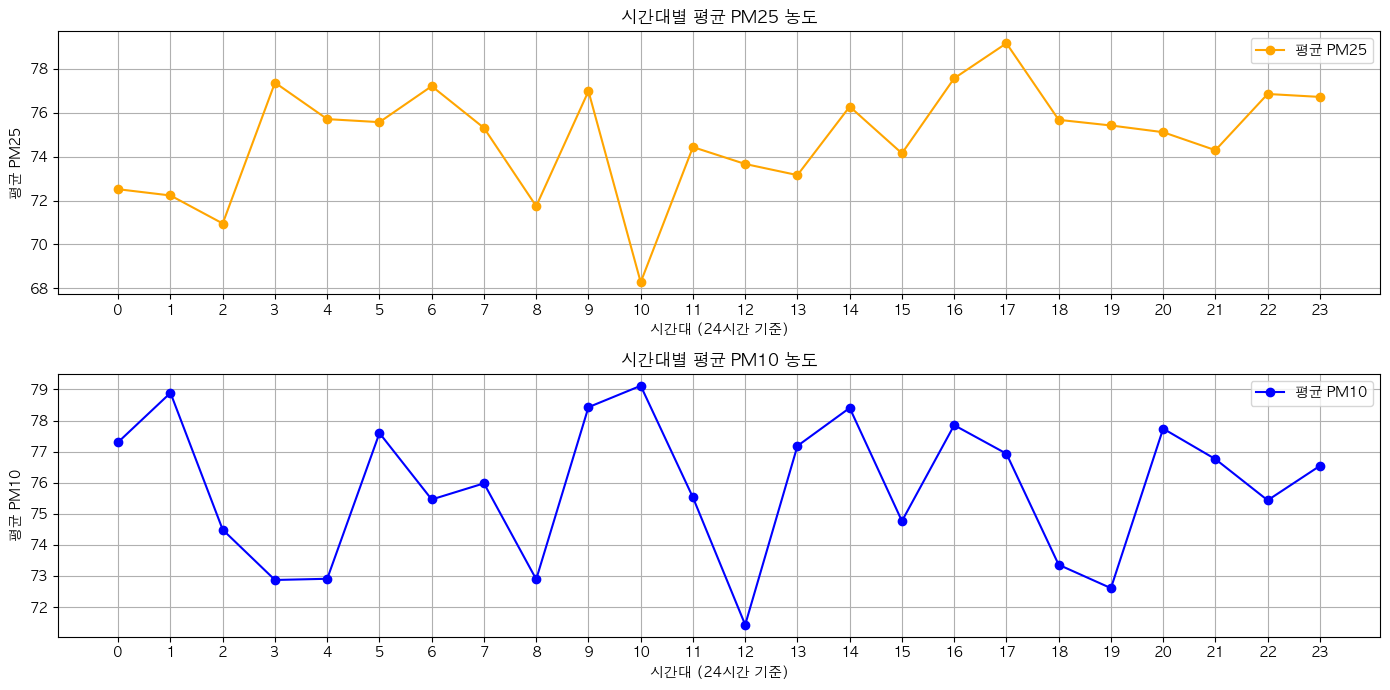

In [17]:
plt.figure(figsize=(14, 7))

# PM25 시간대별 평균 시각화
plt.subplot(2, 1, 1)
plt.plot(hourly_avg.index, hourly_avg['PM25'], marker='o', color='orange', label='평균 PM25')
plt.title('시간대별 평균 PM25 농도')
plt.xlabel('시간대 (24시간 기준)')
plt.ylabel('평균 PM25')
plt.xticks(np.arange(0, 24, step=1))
plt.grid(True)
plt.legend()

# PM10 시간대별 평균 시각화
plt.subplot(2, 1, 2)
plt.plot(hourly_avg.index, hourly_avg['PM10'], marker='o', color='blue', label='평균 PM10')
plt.title('시간대별 평균 PM10 농도')
plt.xlabel('시간대 (24시간 기준)')
plt.ylabel('평균 PM10')
plt.xticks(np.arange(0, 24, step=1))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
